In [1]:
import os
data_dir = os.path.join(os.getcwd(), 'jena')
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values
import matplotlib.pyplot as plt
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
mean = float_data[:200000].mean(axis =0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data/=std

In [4]:
def generator(data, lookback, delay, min_index,max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback = lookback, delay = delay, 
                      min_index = 0, max_index = 200000, shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, 
                      min_index = 200001, max_index = 300000, step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, 
                      min_index = 300001, max_index = None, step = step, batch_size = batch_size)

In [6]:
val_steps = 10000 # shorter than full, which takes forever
test_steps = (len(float_data)-300001 -lookback)
def naive():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
naive()

0.28970482564414013


Epoch 1/5
500/500 [==============================] - 7s 13ms/step - loss: 1.9846 - val_loss: 1.5304
Epoch 2/5
500/500 [==============================] - 7s 13ms/step - loss: 0.7343 - val_loss: 0.3459
Epoch 3/5
500/500 [==============================] - 7s 13ms/step - loss: 0.3540 - val_loss: 0.2890
Epoch 4/5
500/500 [==============================] - 7s 13ms/step - loss: 0.2826 - val_loss: 0.3050
Epoch 5/5
500/500 [==============================] - 7s 13ms/step - loss: 0.2637 - val_loss: 0.3166


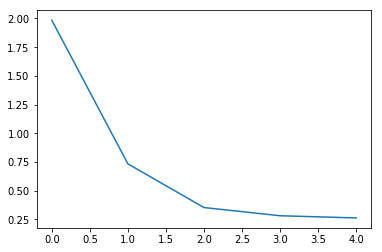

In [9]:
val_steps = 100
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape = (lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
hist = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 5, validation_data = val_gen, validation_steps = val_steps)

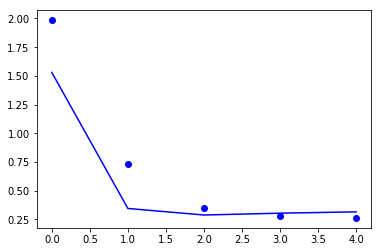

In [11]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],'bo')
plt.plot(hist.history['val_loss'],'b')
plt.show()
model.save('jena_dense.h5')

In [14]:
val_steps = 500
model = Sequential()
model.add(layers.GRU(32,input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(), loss = 'mae')
hist = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 10, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/10
500/500 [==============================] - 66s 132ms/step - loss: 0.3046 - val_loss: 0.2670
Epoch 2/10
500/500 [==============================] - 70s 140ms/step - loss: 0.2855 - val_loss: 0.2708
Epoch 3/10
500/500 [==============================] - 70s 141ms/step - loss: 0.2781 - val_loss: 0.2617
Epoch 4/10
500/500 [==============================] - 71s 141ms/step - loss: 0.2738 - val_loss: 0.2534
Epoch 5/10
500/500 [==============================] - 71s 142ms/step - loss: 0.2700 - val_loss: 0.2719
Epoch 6/10
500/500 [==============================] - 71s 142ms/step - loss: 0.2657 - val_loss: 0.2629
Epoch 7/10
500/500 [==============================] - 71s 142ms/step - loss: 0.2581 - val_loss: 0.2643
Epoch 8/10
500/500 [==============================] - 71s 142ms/step - loss: 0.2533 - val_loss: 0.2751
Epoch 9/10
500/500 [==============================] - 71s 143ms/step - loss: 0.2483 - val_loss: 0.2758
Epoch 10/10
500/500 [==============================] - 71s 142ms/step - l

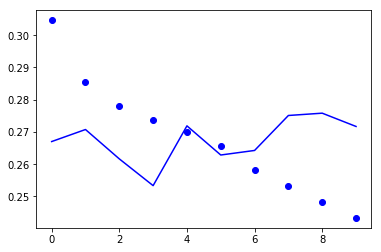

In [15]:
plt.plot(hist.history['loss'],'bo')
plt.plot(hist.history['val_loss'],'b')
plt.show()
model.save('jena_gru.h5')

Epoch 1/10
250/250 [==============================] - 25s 101ms/step - loss: 0.4254 - val_loss: 0.2904
Epoch 2/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3309 - val_loss: 0.2924
Epoch 3/10
250/250 [==============================] - 27s 108ms/step - loss: 0.3244 - val_loss: 0.2554
Epoch 4/10
250/250 [==============================] - 28s 110ms/step - loss: 0.3194 - val_loss: 0.2811
Epoch 5/10
250/250 [==============================] - 28s 111ms/step - loss: 0.3147 - val_loss: 0.2946
Epoch 6/10
250/250 [==============================] - 28s 112ms/step - loss: 0.3131 - val_loss: 0.2493
Epoch 7/10
250/250 [==============================] - 28s 112ms/step - loss: 0.3102 - val_loss: 0.2832
Epoch 8/10
250/250 [==============================] - 28s 113ms/step - loss: 0.3107 - val_loss: 0.2840
Epoch 9/10
250/250 [==============================] - 28s 113ms/step - loss: 0.3080 - val_loss: 0.2512
Epoch 10/10
250/250 [==============================] - 28s 113ms/step - l

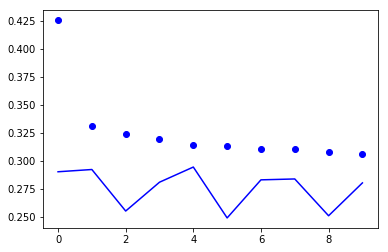

In [16]:
val_steps = 250
model = Sequential()
model.add(layers.GRU(16,input_shape = (None, float_data.shape[-1]), dropout = 0.2, recurrent_dropout = 0.2))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(), loss = 'mae')
hist = model.fit_generator(train_gen, steps_per_epoch = 250, epochs = 10, validation_data = val_gen, validation_steps = val_steps)
plt.plot(hist.history['loss'],'bo')
plt.plot(hist.history['val_loss'],'b')
plt.show()
model.save('jena_gru_dropout.h5')

In [ ]:
# Also bi-directional LSTM and GRU